In [1]:
import torch, fastai, sys, os
from fastai.vision import *
import ants
from ants.core.ants_image import ANTsImage
from jupyterthemes import jtplot
sys.path.insert(0, './exp')
jtplot.style(theme='gruvboxd')

import model
from model import SoftDiceLoss, KLDivergence, L2Loss
import dataloader 
from dataloader import data

47 items written into valid.txt.


In [2]:
torch.cuda.set_device(1)
torch.cuda.current_device()

1

In [3]:
autounet = model.autounet.cuda()
sdl = SoftDiceLoss()
kld = KLDivergence()
l2l = L2Loss()

In [4]:
class AutoUNetCallback(LearnerCallback):
    "Custom callback for implementing `AutoUNet` training loop"
    _order=0
    
    def __init__(self, learn:Learner):
        super().__init__(learn)
    
    def on_batch_begin(self, last_input:Tensor, last_target:Tensor, **kwargs):
        "Store the states to be later used to calculate the loss"
        self.top_y, self.bottom_y = last_target.data, last_input.data
        
    def on_loss_begin(self, last_output:Tuple[Tensor,Tensor], **kwargs):
        "Stroe the states to be later used to calculate the loss"
        self.top_res, self.bottom_res = last_output
        self.z_mean, self.z_log_var = model.hooks.stored[3], model.hooks.stored[4]
        return {'last_output': (self.top_res, self.bottom_res,
                                self.z_mean, self.z_log_var,
                                self.top_y, self.bottom_y)}

In [5]:
class AutoUNetLoss(nn.Module):
    "Combining all the loss functions defined for `AutoUNet`"
    def __init__(self):
        super().__init__()
    
    def forward(self, top_res, bottom_res, z_mean, z_log_var, top_y, bottom_y):
        return sdl(top_res, top_y) + (0.1 * kld(z_mean, z_log_var)) + (0.1 * l2l(bottom_res, bottom_y))

In [6]:
#monkey-patch
def mp_loss_batch(model:nn.Module, xb:Tensor, yb:Tensor, loss_func:OptLossFunc=None, opt:OptOptimizer=None,
               cb_handler:Optional[CallbackHandler]=None)->Tuple[Union[Tensor,int,float,str]]:
    "Calculate loss and metrics for a batch, call out to callbacks as necessary."
    cb_handler = ifnone(cb_handler, CallbackHandler())
    if not is_listy(xb): xb = [xb]
    if not is_listy(yb): yb = [yb]
    out = model(*xb)
    out = cb_handler.on_loss_begin(out)

    if not loss_func: return to_detach(out), to_detach(yb[0])
    loss = loss_func(*out) #modified

    if opt is not None:
        loss,skip_bwd = cb_handler.on_backward_begin(loss)
        if not skip_bwd:                     loss.backward()
        if not cb_handler.on_backward_end(): opt.step()
        if not cb_handler.on_step_end():     opt.zero_grad()

    return loss.detach().cpu()

In [7]:
#monkey-patch
def mp_fit(epochs:int, learn:Learner, callbacks:Optional[CallbackList]=None, metrics:OptMetrics=None)->None:
    "Fit the `model` on `data` and learn using `loss_func` and `opt`."
    assert len(learn.data.train_dl) != 0, f"""Your training dataloader is empty, can't train a model.
        Use a smaller batch size (batch size={learn.data.train_dl.batch_size} for {len(learn.data.train_dl.dataset)} elements)."""
    cb_handler = CallbackHandler(callbacks, metrics)
    pbar = master_bar(range(epochs))
    cb_handler.on_train_begin(epochs, pbar=pbar, metrics=metrics)

    exception=False
    try:
        for epoch in pbar:
            learn.model.train()
            cb_handler.set_dl(learn.data.train_dl)
            cb_handler.on_epoch_begin()
            for xb,yb in progress_bar(learn.data.train_dl, parent=pbar):
                xb, yb = cb_handler.on_batch_begin(xb, yb)
                loss = loss_batch(learn.model, xb, yb, learn.loss_func, learn.opt, cb_handler) #modified
                if cb_handler.on_batch_end(loss): break

            if not cb_handler.skip_validate and not learn.data.empty_val:
                val_loss = validate(learn.model, learn.data.valid_dl, loss_func=learn.loss_func,
                                       cb_handler=cb_handler, pbar=pbar)
            else: val_loss=None
            if cb_handler.on_epoch_end(val_loss): break
    except Exception as e:
        exception = e
        raise
    finally: cb_handler.on_train_end(exception)


In [8]:
 #monkey-patch
def mp_learner_fit(self, epochs:int, lr:Union[Floats,slice]=defaults.lr,
                   wd:Floats=None, callbacks:Collection[Callback]=None)->None:
    "Fit the model on this learner with `lr` learning rate, `wd` weight decay for `epochs` with `callbacks`."
    lr = self.lr_range(lr)
    if wd is None: wd = self.wd
    if not getattr(self, 'opt', False): self.create_opt(lr, wd)
    else: self.opt.lr,self.opt.wd = lr,wd
    callbacks = [cb(self) for cb in self.callback_fns + listify(defaults.extra_callback_fns)] + listify(callbacks)
    fit(epochs, self, metrics=self.metrics, callbacks=self.callbacks+callbacks)

In [9]:
#monkey-patch
def mp_validate(model:nn.Module, dl:DataLoader, loss_func:OptLossFunc=None, cb_handler:Optional[CallbackHandler]=None,
             pbar:Optional[PBar]=None, average=True, n_batch:Optional[int]=None)->Iterator[Tuple[Union[Tensor,int],...]]:
    "Calculate `loss_func` of `model` on `dl` in evaluation mode."
    model.eval()
    with torch.no_grad():
        val_losses,nums = [],[]
        if cb_handler: cb_handler.set_dl(dl)
        for xb,yb in progress_bar(dl, parent=pbar, leave=(pbar is not None)):
            if cb_handler: xb, yb = cb_handler.on_batch_begin(xb, yb, train=False)
            val_loss = loss_batch(model, xb, yb, loss_func, cb_handler=cb_handler) #modified
            val_losses.append(val_loss)
            if not is_listy(yb): yb = [yb]
            nums.append(first_el(yb).shape[0])
            if cb_handler and cb_handler.on_batch_end(val_losses[-1]): break
            if n_batch and (len(nums)>=n_batch): break
        nums = np.array(nums, dtype=np.float32)
        if average: return (to_np(torch.stack(val_losses)) * nums).sum() / nums.sum()
        else:       return val_losses

In [10]:
#monkey-patch
def mp_learner_validate(self, dl=None, callbacks=None, metrics=None):
    "Validate on `dl` with potential `callbacks` and `metrics`."
    dl = ifnone(dl, self.data.valid_dl)
    metrics = ifnone(metrics, self.metrics)
    cb_handler = CallbackHandler(self.callbacks + ifnone(callbacks, []), metrics)
    cb_handler.on_train_begin(1, None, metrics); cb_handler.on_epoch_begin()
    val_metrics = validate(self.model, dl, self.loss_func, cb_handler)
    cb_handler.on_epoch_end(val_metrics)
    return cb_handler.state_dict['last_metrics']

In [11]:
from fastai.basic_train import loss_batch, fit, validate

In [12]:
loss_batch = mp_loss_batch
fit = mp_fit
validate = mp_validate
Learner.fit = mp_learner_fit
Learner.validate = mp_learner_validate

In [13]:
def dice_coefficient(last_output:Tensor, last_target:Tensor):
    "Metric based on dice coefficient"
    pred, targ = last_output[0], last_target
    return 2 * (pred * targ).sum() / ((pred**2).sum() + (targ**2).sum())

In [14]:
auto_unet_loss = AutoUNetLoss()

In [15]:
learner = Learner(data, autounet, loss_func=auto_unet_loss)

In [16]:
autounet_cb = AutoUNetCallback(learner)

In [17]:
learner.callbacks.append(autounet_cb)

In [17]:
learner.lr_find()

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


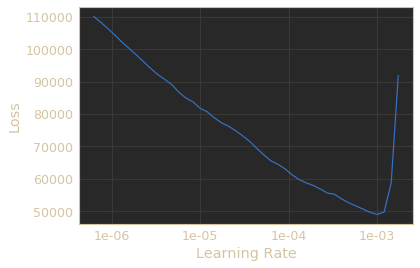

In [18]:
learner.recorder.plot()

In [20]:
learner.save("trained_model", return_path=True)

PosixPath('/home/ubuntu/MultiCampus/MICCAI_BraTS_2019_Data_Training/models/trained_model.pth')

In [20]:
learner = learner.load("trained_model", device=1)

In [20]:
learner.metrics = [dice_coefficient]

In [23]:
learner.fit_one_cycle(1, max_lr=3e-04)

epoch,train_loss,valid_loss,dice_coefficient,time
0,11968.476562,11397.278320,0.728514,31:11


In [24]:
learner.fit_one_cycle(10, max_lr=3e-04)

epoch,train_loss,valid_loss,dice_coefficient,time
0,10191.506836,11200.149414,0.737531,32:57
1,11503.087891,11923.188477,0.644095,32:46
2,11965.605469,11864.083984,0.658343,32:44
3,11030.506836,11926.581055,0.679012,32:11
4,10746.779297,11227.884766,0.706088,32:13
5,10609.997070,11073.265625,0.709225,32:19
6,10128.075195,10866.394531,0.730715,32:28
7,8688.515625,10695.497070,0.721070,32:36
8,9033.506836,10564.528320,0.755184,32:44
9,8694.732422,10569.330078,0.755437,30:29


In [26]:
learner.save("trained_model_1cycle", return_path=True)

PosixPath('/home/ubuntu/MultiCampus/MICCAI_BraTS_2019_Data_Training/models/trained_model_1cycle.pth')

In [18]:
learner = learner.load("trained_model_1cycle", device=1)

In [ ]:
learner.fit_one_cycle(10, max_lr=3e-04)

epoch,train_loss,valid_loss,dice_coefficient,time
0,10392.399414,9580.957031,0.736880,31:50
1,10042.610352,10256.254883,0.701320,30:34
2,10119.898438,10275.036133,0.689501,31:14
3,10711.199219,10155.269531,0.584035,31:59
4,9853.235352,10081.066406,0.673109,31:24
5,9889.505859,9921.931641,0.688964,31:13
6,8726.832031,9781.743164,0.708290,31:18
7,8652.989258,9700.190430,0.732054,31:08
